Varroa Mite Detection 1.5 Big Data Set

In [4]:
# Cell Block 1: Importing Libraries
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold, train_test_split
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
# Cell Block 2: Load Data and Preprocess

df = pd.read_csv('labels_augmented.csv')

df['filename'] = df['filename'].apply(lambda fn: os.path.join('rotations_flips', fn.strip()))

filepaths = df['filename'].values
labels = df['has_mite'].values

In [6]:
# Cell Block 3: K-Fold Cross-Validation

# Early stopping callback
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    # min_delta=1e-4,
    restore_best_weights=True
)

k = 10  # Number of folds
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

fold = 1
all_test_accuracies = []
best_epochs = []

# Model creation function
def create_model():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Preprocessing function
def preprocess(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def load_img(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = img / 255.0
        return img, label

    return ds.map(load_img).batch(32).prefetch(tf.data.AUTOTUNE)

for trainval_index, test_index in skf.split(filepaths, labels):
    print(f"\n🧪 Fold {fold} -----------------------------")

    # Split into trainval and test
    X_trainval, X_test = filepaths[trainval_index], filepaths[test_index]
    y_trainval, y_test = labels[trainval_index], labels[test_index]

    # Further split trainval into train and val (e.g. 80/20)
    val_split = int(0.8 * len(X_trainval))
    X_train, X_val = X_trainval[:val_split], X_trainval[val_split:]
    y_train, y_val = y_trainval[:val_split], y_trainval[val_split:]


    # Preprocess each split
    train_ds = preprocess(X_train, y_train)
    val_ds = preprocess(X_val, y_val)
    test_ds = preprocess(X_test, y_test)



    # Train model with early stopping
    model = create_model()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[earlystop],
        verbose=1
    )

    # Record best epoch (smallest val_loss)
    best_epoch = np.argmin(history.history['val_loss']) + 1
    best_epochs.append(best_epoch)
    print(f"🏁 Best epoch for Fold {fold}: {best_epoch}")

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)
    all_test_accuracies.append(test_acc)
    print(f"✅ Fold {fold} test accuracy: {test_acc:.4f}")

    fold += 1

# Calculate mean best epoch
ep_mean = int(np.round(np.mean(best_epochs)))
print(f"\n📌 Mean optimal epoch across folds: {ep_mean}")


🧪 Fold 1 -----------------------------
Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 378ms/step - accuracy: 0.5754 - loss: 0.9007 - val_accuracy: 0.5922 - val_loss: 0.6773
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 33s 355ms/step - accuracy: 0.6091 - loss: 0.6765 - val_accuracy: 0.5922 - val_loss: 0.6770
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 33s 354ms/step - accuracy: 0.6091 - loss: 0.6747 - val_accuracy: 0.5922 - val_loss: 0.6770
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 33s 354ms/step - accuracy: 0.6091 - loss: 0.6738 - val_accuracy: 0.5922 - val_loss: 0.6877
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 383ms/step - accuracy: 0.6091 - loss: 0.6857 - val_accuracy: 0.5922 - val_loss: 0.6846
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 378ms/step - accuracy: 0.6091 - loss: 0.6821 - val_accuracy: 0.5922 - val_loss: 0.6823
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 375ms/step - accuracy: 0.6091 - loss: 0.6793 - val_accuracy: 0.5922 - val_loss: 0.6805
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 34s 370ms/s

In [7]:
# Cell Block 4: Final Model Training on data again, but for ep_mean Epochs (no validation needed)

## NOTE: THIS IS NOT TESTING ON HIDDEN DATA - IT WAS TECHNICALLY SEEN IN THE k-FOLD.
## CAN TALK ABOUT THIS TO AYUSHMAN

# Split all data into 80% train and 20% test
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    filepaths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Use your same preprocess function
train_final_ds = preprocess(X_train_final, y_train_final)
test_final_ds = preprocess(X_test_final, y_test_final)

# Create and train model with ep_mean
final_model = create_model()
final_model.fit(
    train_final_ds,
    epochs=ep_mean,
    verbose=1
)


Epoch 1/12
104/104 ━━━━━━━━━━━━━━━━━━━━ 38s 361ms/step - accuracy: 0.5615 - loss: 0.8240
Epoch 2/12
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 337ms/step - accuracy: 0.5981 - loss: 0.6698
Epoch 3/12
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 337ms/step - accuracy: 0.6402 - loss: 0.6361
Epoch 4/12
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 342ms/step - accuracy: 0.6960 - loss: 0.5788
Epoch 5/12
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 336ms/step - accuracy: 0.7496 - loss: 0.5050
Epoch 6/12
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 341ms/step - accuracy: 0.8017 - loss: 0.4266
Epoch 7/12
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 342ms/step - accuracy: 0.8233 - loss: 0.3787
Epoch 8/12
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 342ms/step - accuracy: 0.8901 - loss: 0.2749
Epoch 9/12
104/104 ━━━━━━━━━━━━━━━━━━━━ 36s 345ms/step - accuracy: 0.8986 - loss: 0.2333
Epoch 10/12
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 338ms/step - accuracy: 0.9143 - loss: 0.1930
Epoch 11/12
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 336ms/step - accuracy: 0.8851 - loss: 0.2462
Epoch 12/12
104/104

In [8]:
# Cell Block 5: Final Evaluation

# Evaluate final model on the 20% test set
final_test_loss, final_test_acc = final_model.evaluate(test_final_ds, verbose=0)

# Report both results
print(f"\n📊 {k}-Fold Test Accuracy: {np.mean(all_test_accuracies):.4f} ± {np.std(all_test_accuracies):.4f}")
print(f"🏁 Final model test accuracy (trained on 80% for {ep_mean} epochs): {final_test_acc:.4f}")


📊 10-Fold Test Accuracy: 0.6526 ± 0.1004
🏁 Final model test accuracy (trained on 80% for 12 epochs): 0.6618


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


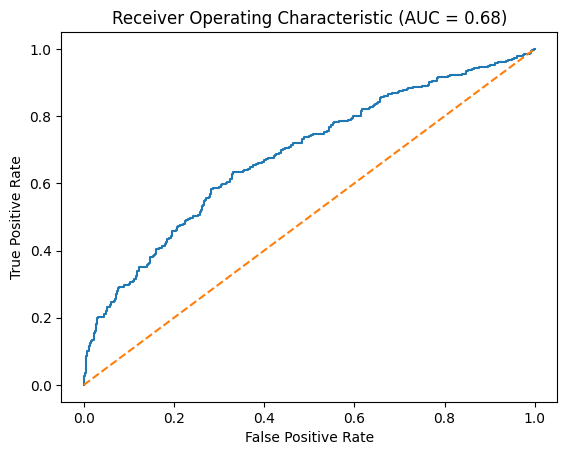

Precision: 0.66
Recall:    0.30
F1 Score:  0.42


: 

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, roc_curve, auc, f1_score, recall_score
import matplotlib.pyplot as plt

# 1. Extract true labels and model scores from your hold-out dataset
y_true = np.concatenate([y.numpy() for x, y in test_final_ds], axis=0)
y_pred_prob = final_model.predict(test_final_ds)

# 2. If your model outputs two probabilities (one per class), take the “positive” class
if y_pred_prob.ndim > 1 and y_pred_prob.shape[1] > 1:
    y_scores = y_pred_prob[:, 1]
else:
    y_scores = y_pred_prob.ravel()

# 3. Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# 4. Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr)               # ROC curve
plt.plot([0, 1], [0, 1], linestyle='--')  # chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (AUC = {roc_auc:.2f})')
plt.show()



# 1. Turn your predicted probabilities into binary preds (threshold = 0.5)
y_pred = (y_scores >= 0.5).astype(int)

# 2. Compute precision, recall, F1
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")
